# RNN
> RNN은 시계열 데이터 또는 순차 데이터를 처리하기 위한 신경망

> 시간에 따라 순차적으로 상태(hidden state)를 유지하며 계산하는 구조


## 기본수식
> 은닉 상태 업데이트: h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)

> 출력 계산: y_t = W_hy * h_t + b_y

> 순환구조 핵심: 과거 정보는 h_t-1로 은닉 상태에 저장되고, 현재 입력과 함께 다음 상태 계산에 사용됨


## 구성요소
* x_t: 시점 t의 입력
* h_t: 시점 t의 은닉 상태 (이전 정보 기억 포함)
* w_xh: 입력 → 은닉층 가중치
* w_hh: 은닉 → 은닉 가중치
* b_h: 은닉층 바이어스
* w_hy: 은닉 → 출력층 가중치
* b_y: 출력층 바이어스
* y_t: 시점 t의 출력 예측값


## 동작방식
> 출력 y_t가 정답과 가까워지도록 손실을 최소화해나감
1. Forward pass
* 시간축 따라 순서대로 h 계산
* 마지막 hidden state를 사용해 y_pred 계산

2. Loss 계산
* MSELoss: 예측값과 실제값의 평균제곱오차 계산

3. Backward pass
* 각 시점의 출력 오류를 시간축 따라 역으로 전파
* .backward() 호출로 모든 파라미터에 대해 그래디언트 계산→ Backpropagation Through Time (BPTT)
* optimizer.step() 으로 파라미터 업데이트

4. Epoch 반복


## 요약흐름도
> 각 RNN 셀은 입력 x_t와 이전 상태 h_t-1를 받아 새로운 은닉 상태 h_t 생성

> 마지막 은닉 상태로부터 출력을 계산 (예측)
```
[시계열 입력: x₁ ~ xₜ₀] 
          ↓
    ┌────────────┐
    │ RNN Cell 1 │  ←── h₀ (초기값 0)
    └────────────┘
          ↓ h₁
    ┌────────────┐
    │ RNN Cell 2 │
    └────────────┘
          ↓ ...
    ┌────────────┐
    │ RNN Cell t │
    └────────────┘
          ↓ hₜ
      ŷₜ = hₜ × W_hy + b_y
```


## 슬라이딩 윈도우
> 시계열 데이터를 일정 길이(window_size)로 나눠서 학습 데이터 생성하는 방법
* RNN은 일정 길이의 시퀀스를 입력으로 받아야 하므로, df_train의 각 시계열에서 (window_size + 1) 만큼 잘라서 학습 샘플을 생성


## RNN을 사용한 이유
* 각 열을 시간 순서에 따라 나열된 시계열 데이터로 봤음 (0.3씩 증가)
* RNN은 입력을 시간 순서 포함한 시퀀스로, 순서 정보를 고려하는 특성을 가져 시계열을 처리하기에 적절하다고 판단
* ANN은 순서를 고려하지 않고 입력이 고정된 벡터값이라 시계열 처리하기에는 RNN이 더 낫다고 생각함
* CNN의 경우 이미지나 고정된 윈도우 크기 내의 로컬 특징을 추출하기에 더 적합해 시간 순서에 따른 장기 의존성을 잘 반영하진 못하다고 판단해 마찬가지로 RNN이 더 낫다고 생각함


# 코드 설명
## RNN 구조
```
x₁ ~ x₁₀ → h₁ ~ h₁₀ → h_last → ŷ₁
    ↓ (x₂ ~ x₁₁)          ↓
  반복 학습               예측 반복
```


## 동작순서
1. CSV 로딩 및 정규화
* Z-score: (x - mean) / std
* 학습/테스트 데이터 동일한 기준으로 정규화

2. 슬라이딩 윈도우 생성
* 연속된 11개 값 중 앞 10개는 입력, 마지막 1개는 출력으로 나눔

3. RNN 학습
* 파라미터 직접 정의
* 순서대로 hidden state 업데이트
* 마지막 hidden state를 통해 예측값 계산 → loss 계산 → 역전파

4. 테스트 예측
* 앞 101개 컬럼을 기반으로 이후 컬럼을 한 스텝씩 반복 예측
* 테스트 시 다음 값을 예측하고 입력으로 재사용하는 구조 → Auto-regressive 방식

5. 역정규화 후 결과 저장


## Loss값 분석
1. 초기 손실
> Epoch 0 | Loss: 2.585064
* 초기 손실값이 높은데, 이는 모델이 초기에는 데이터를 제대로 예측하지 못함을 의미함
* 모델이 학습하기 전, 아무것도 모르는 상태라 잘못된 예측을 할 수 밖에 없으므로 자연스러운 현상임

2. 손실 감소
> Epoch 400 ~ 2000: 손실이 0.23대에서 서서히 안정화됨
* 그래프에서도 보이듯이 초반 200 epoch까지 빠르게 감소하고 이후로는 완만한 수렴 곡선을 보임

3. 최종 손실
> Epoch 2000 | Loss: 0.233091
* 1000 epoch 이후로는 점진적인 감소가 이루어지고 있으며, 오버피팅 없이 안정적으로 수렴하고 있는 모습 확인 가능


## 추가적인 고려사항
1. 실제 데이터가 시계열이 아닐 수 있음 
* 주어진 데이터가 시계열 데이터라는 확실한 정보가 없음
* 만약 데이터가 시계열 데이터가 아니라면 순서에 무관한 패턴을 학습하는 ANN 등 다른 모델이 더 적합했을 수 있음
* 각 row를 슬라이딩할 때, column 순서가 시간 순이 아니니면 순서가 무의미해질 수 있음

2. hidden size
* 현재 코드의 hidden size가 작을 수 있음
* 또한, 단층구조라 복잡한 시계열 패턴을 충분히 표현하기엔 부족할 수 있음
* 더 깊은 RNN이나 LSTM이 더 적합할 수 있음

Epoch 0 | Loss: 2.585064
Epoch 200 | Loss: 0.248024
Epoch 400 | Loss: 0.240829
Epoch 600 | Loss: 0.238088
Epoch 800 | Loss: 0.236452
Epoch 1000 | Loss: 0.235516
Epoch 1200 | Loss: 0.234696
Epoch 1400 | Loss: 0.234199
Epoch 1600 | Loss: 0.233810
Epoch 1800 | Loss: 0.233442
Epoch 2000 | Loss: 0.233091


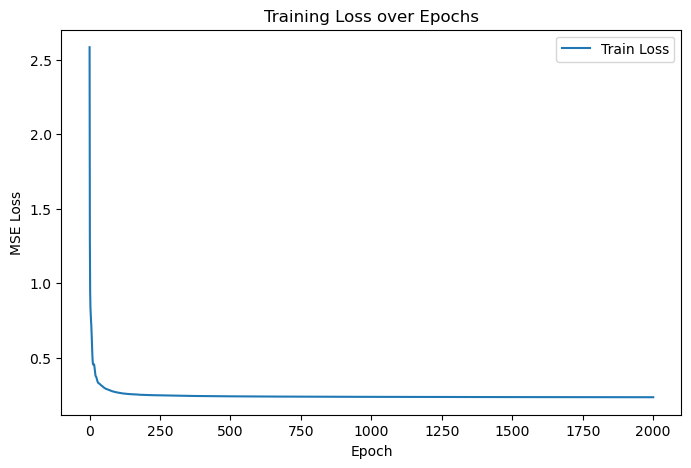

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
# Intel의 OpenMP 라이브러리 중복된 라이브러리 로딩 문제 발생 해결용도
# 중복 라이브러리 로딩 경고를 무시하고 실행을 계속하도록 허용하도록 하기 위함
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# 데이터 로딩
df_train = pd.read_csv("practicalDS_final_train.csv")
df_test = pd.read_csv("practicalDS_final_test.csv")

# 컬럼별 정규화 (Z-score)
train_mean = df_train.mean()
train_std = df_train.std()
df_train_norm = (df_train - train_mean) / train_std
df_test_norm = (df_test - train_mean) / train_std

# 하이퍼파라미터
window_size = 10
input_size = 1
hidden_size = 16
output_size = 1
learning_rate = 0.01
epochs = 2000

# 슬라이딩 윈도우 시퀀스 생성
train_sequences = []
for row in df_train_norm.values:
    for i in range(len(row) - window_size):
        window = row[i:i + window_size + 1]
        train_sequences.append(window)

train_sequences = np.array(train_sequences)
train_sequences = torch.tensor(train_sequences, dtype=torch.float32)

x_train = train_sequences[:, :-1].unsqueeze(-1)
y_train = train_sequences[:, -1].unsqueeze(-1)

# RNN 파라미터 정의 및 초기화
torch.manual_seed(0)
W_xh = torch.nn.Parameter(torch.randn(input_size, hidden_size))
W_hh = torch.nn.Parameter(torch.randn(hidden_size, hidden_size))
b_h = torch.nn.Parameter(torch.randn(hidden_size))
W_hy = torch.nn.Parameter(torch.randn(hidden_size, output_size))
b_y = torch.nn.Parameter(torch.randn(output_size))
params = [W_xh, W_hh, b_h, W_hy, b_y]

optimizer = torch.optim.Adam(params, lr=learning_rate)
loss_fn = torch.nn.MSELoss()

losses = []

# 학습
for epoch in range(epochs + 1):
    h = torch.zeros(x_train.size(0), hidden_size)
    for t in range(window_size):
        x_t = x_train[:, t, :]
        h = torch.tanh(x_t @ W_xh + h @ W_hh + b_h)
    y_pred = h @ W_hy + b_y
    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
        
# 학습 후 손실 그래프 출력
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

# 테스트 데이터 예측
df_test_filled = df_test.copy()
cols = list(df_test.columns)
known_cols = cols[:101]
missing_cols = cols[101:]

for i in range(len(df_test)):
    series = df_test_norm.loc[i, known_cols].tolist()
    for c in missing_cols:
        x_seq = torch.tensor(series[-window_size:], dtype=torch.float32).view(1, window_size, 1)
        h = torch.zeros(1, hidden_size)
        for t in range(window_size):
            x_t = x_seq[:, t, :]
            h = torch.tanh(x_t @ W_xh + h @ W_hh + b_h)
        y_next_norm = (h @ W_hy + b_y).item()
        
        # 역정규화
        y_next = y_next_norm * train_std[c] + train_mean[c]
        df_test_filled.at[i, c] = y_next
        
        # 다음 스텝 예측 위해 정규화된 값 추가
        series.append(y_next_norm)

# 결과 저장
name = "이유정"
df_test_filled.to_csv(f"practicalDS_final_test_{name}.csv", index=False)

# 데이터 정규화
## Z-score
> x_norm = x-평균/표준편차

> 단위(scale)이 서로 다른 feature 간의 영향을 균등하게 만들기 위한 목적으로 사용됨


## 사용한 이유
> Feature 간 스케일 차이가 큼
* min 값은 대부분 0.0001 ~ 1 수준인데, max는 100 이상인 feature도 많음
* mean은 어떤 feature는 2, 어떤 feature는 27, std 역시 0.5 ~ 14 사이로 편차가 큼
* 이렇게 feature마다 값의 범위와 분포가 매우 다르면, 정규화 없이 RNN이나 어떤 신경망을 학습시키면 모델은 값이 큰 feature에 더 많은 가중치를 부여하려는 경향이 생기고, 작은 스케일의 feature는 무시될 수 있음

> RNN에 가장 적합한 정규화 방법이라 판단했음
* RNN은 시계열의 각 타임스텝에서 반복 연산을 수행함
* RNN에서 가장 흔히 쓰이는 활성화 함수는 tanh인데, tanh(x)의 입력이 클 경우 기울기가 0에 수렴하는 Gradient vanishing 문제가 생길 수 있음
* tanh(x)가 적절히 작동하기 위해선 입력값이 -1 ~ 1 정도의 범위에 있어야 안정적인데, Z-score 정규화는 평균을 0으로, 분산을 1로 맞춰주어 입력값을 적정 범위 안에 맞춰주므로 가장 안정적이라고 생각했음
* RNN은 시퀀스 전체를 순차적으로 처리하기 때문에, 한 시점이라도 값의 스케일이 크면 전체 흐름에 방해됨
* Z-score는 모든 시점에서 데이터 분포를 통일시켜주기 때문에 Time step 간 학습 편향을 줄이고 Backpropagation through time이 안정화 됨

Feature Scale Summary:
           min         max       mean        std
0.0   1.000189    2.999828   2.001004   0.578201
0.3   0.338846   49.636017   7.428063   6.519236
0.6   0.223097   66.805992  15.523831  13.326464
0.9   0.268232   77.331213  19.794117  14.697757
1.2   0.189158   78.606842  22.147421  14.926951
...        ...         ...        ...        ...
28.8  0.000143  119.001854  27.857794  13.768803
29.1  0.000216  128.016007  27.749999  13.683296
29.4  0.000220  127.814591  27.950012  13.798076
29.7  0.000138  142.474616  27.946075  13.771135
30.0  0.000125  129.055245  27.880569  13.720719

[101 rows x 4 columns]


<Figure size 1500x700 with 0 Axes>

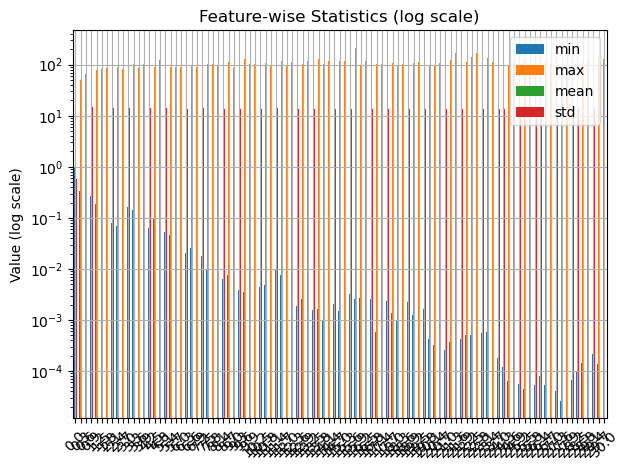

In [2]:
# 데이터 확인용 코드

import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
df_train = pd.read_csv("practicalDS_final_train.csv")

# 입력 특성만 추출
x_label = list(df_train.columns[:-3])
X = df_train[x_label]

# 통계 요약 계산
summary = pd.DataFrame({
    'min': X.min(),
    'max': X.max(),
    'mean': X.mean(),
    'std': X.std()
})

print("Feature Scale Summary:")
print(summary)

# 시각화 (로그 스케일 막대그래프)
plt.figure(figsize=(15, 7))
summary[['min', 'max', 'mean', 'std']].plot(kind='bar', logy=True)
plt.title("Feature-wise Statistics (log scale)")
plt.ylabel("Value (log scale)")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()